In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
from datetime import datetime


In [2]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

In [3]:
train_dir = './data/FlagsMashupBot/autoencoder_images/train/0/'
train_files = [f for f in os.listdir(train_dir) if not f.startswith('.')]
val_dir = './data/FlagsMashupBot/autoencoder_images/val/0/'
val_files = [f for f in os.listdir(val_dir) if not f.startswith('.')]
test_dir = './data/FlagsMashupBot/autoencoder_images/test/0/'
test_files = [f for f in os.listdir(test_dir) if not f.startswith('.')]

In [4]:
len(train_files), len(val_files), len(test_files)

(3440, 737, 738)

In [5]:
BATCH_SIZE = 8
IMG_HEIGHT = 256
IMG_WIDTH = 256
# STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [6]:
train_dir = './data/FlagsMashupBot/autoencoder_images/train/'
val_dir = './data/FlagsMashupBot/autoencoder_images/val/'
test_dir = './data/FlagsMashupBot/autoencoder_images/test/'
image_generator = ImageDataGenerator(rescale=1./255)
train_data_gen = image_generator.flow_from_directory(
    train_dir, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    class_mode='input')
val_data_gen = image_generator.flow_from_directory(
    val_dir, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    class_mode='input')
test_data_gen = image_generator.flow_from_directory(
    test_dir, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    class_mode='input')

Found 3440 images belonging to 1 classes.
Found 737 images belonging to 1 classes.
Found 738 images belonging to 1 classes.


In [7]:
a = next(train_data_gen)

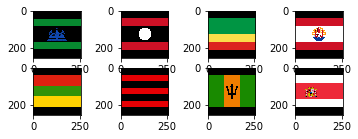

In [8]:
plt.figure()
for i in range(BATCH_SIZE):
    plt.subplot(BATCH_SIZE/2, BATCH_SIZE/2, i+1)
    plt.imshow(a[0][i])

In [9]:
img_width, img_height = IMG_WIDTH, IMG_HEIGHT

In [10]:
input_img = Input(shape=(img_width, img_height, 3))

In [11]:
input_img

<tf.Tensor 'input_1:0' shape=(None, 256, 256, 3) dtype=float32>

In [12]:
conv_shape = (3, 3)

In [13]:
x = Conv2D(24, conv_shape, activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, conv_shape, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, conv_shape, activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [14]:
encoded

<tf.Tensor 'max_pooling2d_2/Identity:0' shape=(None, 32, 32, 16) dtype=float32>

In [15]:
x = Conv2D(16, conv_shape, activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, conv_shape, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(24, conv_shape, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, conv_shape, activation='sigmoid', padding='same')(x)

In [16]:
decoded

<tf.Tensor 'conv2d_6/Identity:0' shape=(None, 256, 256, 3) dtype=float32>

In [17]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 24)      672       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 24)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      3472      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0     

In [18]:
# # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler
# def scheduler(epoch):

#     if epoch < 10:
#         return 0.001
#     else:
#         return 0.001 * tf.math.exp(0.1 * (10 - epoch))

In [19]:
log_dir = "./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_cb = TensorBoard(
    log_dir=log_dir, 
    profile_batch=0)

es_cb = EarlyStopping(
    monitor='val_loss',
    verbose=True,
    patience=12,
    min_delta=0.0001, 
    restore_best_weights=True)

lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=True,
    patience=6,
    mi_delta=0.0001)

cb = [tb_cb, es_cb, lr_cb]

In [ ]:
autoencoder_train = autoencoder.fit(
    train_data_gen, 
    epochs=500, 
    shuffle=True,
    validation_data=val_data_gen,
    callbacks=cb)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 430 steps, validate for 93 steps
Epoch 1/500
430/430 [==============================] - 11s 25ms/step - loss: 0.6937 - val_loss: 0.6926
Epoch 2/500
430/430 [==============================] - 11s 25ms/step - loss: 0.6915 - val_loss: 0.6903
Epoch 3/500
430/430 [==============================] - 11s 25ms/step - loss: 0.6888 - val_loss: 0.6874
Epoch 4/500
430/430 [==============================] - 11s 25ms/step - loss: 0.6857 - val_loss: 0.6842
Epoch 5/500
430/430 [==============================] - 11s 25ms/step - loss: 0.6821 - val_loss: 0.6803
Epoch 6/500
430/430 [==============================] - 11s 25ms/step - loss: 0.6777 - val_loss: 0.6755
Epoch 7/500
430/430 [==============================] - 11s 25ms/step - loss: 0.6720 - val_loss: 0.6692
Epoch 8/500
430/430 [==============================] - 11s 25ms/step - loss: 0.6646 - val_loss: 0.6610
Epoch 9/500
430/430 [==============================] - 11s 25ms/step - loss: 0.6553

In [26]:
test_images_set = next(test_data_gen)[0]

In [27]:
pred = autoencoder_train.model.predict(test_images_set)

In [28]:
pred.shape

(8, 256, 256, 3)

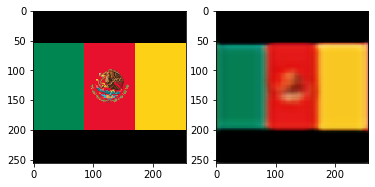

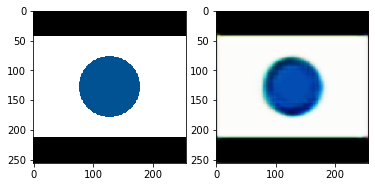

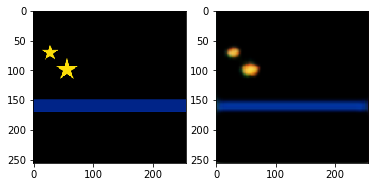

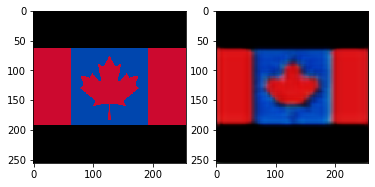

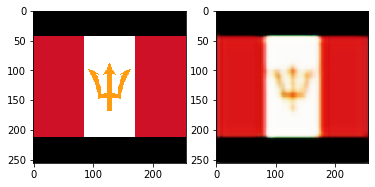

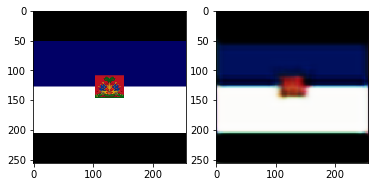

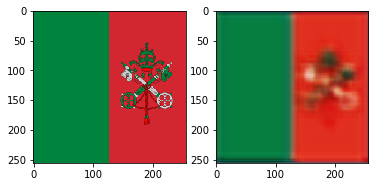

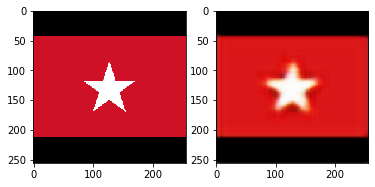

In [29]:
for tr_im, pr_im in zip(test_images_set, pred):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(tr_im)
    plt.subplot(1,2,2)
    plt.imshow(pr_im)    